In [47]:
import numpy as np
from spectral_cube import SpectralCube
from astropy.io import fits
from reproject import reproject_interp
from tqdm.auto import tqdm
import pyspeckit
from astropy.table import Table

In [72]:
def get_cube(cube_filename):
    
    hdu = fits.open(cube_filename)[0]
    hdu.header['BUNIT'] = 'Jy/beam'
    
    cube = SpectralCube.read(hdu)
    cube.allow_huge_operations = True
    cube = cube.to('K')
    return(cube)

def reproject_index_map(cube, index_map_hdu):
        
    # Create 2D header
    header_2d = cube.hdu.header.copy()
    del header_2d['*3*']
    header_2d['NAXIS'] = header_2d['WCSAXES'] = 2 
    index_map_data, _ = reproject_interp(index_map_hdu, header_2d, order='nearest-neighbor')
    
    return(index_map_data)

def average_spectrum_for_indexes(cube, index_map_hdu):
    
    # Regrid
    print('[INFO] Regridding index map...')
    index_map = reproject_index_map(cube, index_map_hdu)
    
    # Load the data cube
    unique_indexes = np.unique(index_map)
    spectra_dict = {}

    i = 0
    for index in tqdm(unique_indexes):
        
        
        # Create a mask for the current index
        mask = (index_map == index)

        # If the cube is not loaded in memory, the following approach is more memory efficient
        # masked_cube = cube.with_mask(mask[:, :, np.newaxis])
        masked_cube = cube.with_mask(mask)

        # Calculate the mean spectrum for the masked region
        mean_spectrum = masked_cube.mean(axis=(1, 2))

        spectra_dict[index] = mean_spectrum

        i=+1
        
    return spectra_dict

def fit_gaussian(spectrum):
    sp = pyspeckit.Spectrum(data=spectrum.value, xarr=spectrum.spectral_axis.value)
    sp.specfit.fittype = 'gaussian'
    sp.specfit(guesses=[spectrum.max().value, spectrum.spectral_axis[spectrum.argmax()].value, 1.0])
    return sp.specfit.parinfo

In [71]:
# Define files 
index_map_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_cont/ACES_leaf_mask_3_1_mp179_pb0.55_pp6_pm2_ar3.0_sm25.fits"
cube_hnco_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m7mtp_lowres/HNCO_7m12mTP_CubeMosaic_downsampled9_downsampledspectrally.fits"
cube_cs_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_lowres/CS21_CubeMosaic_downsampled9_float32.fits"
cube_hc3n_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_lowres/CS21_CubeMosaic_downsampled9_float32.fits"
cube_sio_filename = "/Users/abarnes/Dropbox/work/scratch/ACES1/data/12m_lowres/SiO21_CubeMosaic_downsampled9_float32.fits"

#Load cube
cube_hnco = get_cube(cube_hnco_filename)
cube_cs = get_cube(cube_cs_filename)
cube_hc3n = get_cube(cube_hc3n_filename)
cube_sio = get_cube(cube_sio_filename)

#Regrid index map 
index_map_hdu = fits.open(index_map_filename)[0]

In [73]:
# Get spectrum 
average_spectra_hnco = average_spectrum_for_indexes(cube_hnco, index_map_hdu)
average_spectra_cs = average_spectrum_for_indexes(cube_cs, index_map_hdu)
average_spectra_hc3n = average_spectrum_for_indexes(cube_hc3n, index_map_hdu)
average_spectra_sio = average_spectrum_for_indexes(cube_sio, index_map_hdu)

[INFO] Regridding index map...


  0%|          | 0/658 [00:00<?, ?it/s]

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


KeyboardInterrupt: 

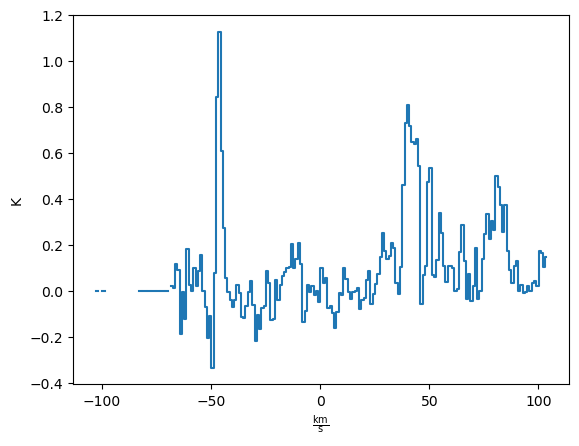

In [65]:
average_spectra_hnco[list(average_spectra_hnco.keys())[2]].quicklook()

In [48]:
# Fit Gaussians and compile results
results = []
for index, spectrum in average_spectra.items():
    fit = fit_gaussian(spectrum)
    amplitude, center, width = fit[0].value, fit[1].value, fit[2].value
    results.append((index, amplitude, center, width))

# Convert results to Astropy table
table = Table(rows=results, names=("Index", "Amplitude", "Center", "Width"))
print(table)

# #Get mass
# Mass = mass_calc(props['flux'].quantity.value, freq, htemp_bl_mean, distance[cloud], gas2dust=141)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,200 [pyspeckit.spectrum.interactive]
Index     Amplitude           Center            Width       
----- ----------------- ----------------- ------------------
  0.0 0.235106443784198 43.89817136759969 23.363442481800504
